In [60]:
import requests
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

import spacy
nlp = spacy.load('en_core_web_sm')

### Load patent and classification information

In [2]:
def readTSV(fn):
    return (pd.DataFrame(pd.read_csv(fn, sep='\t')))

In [3]:
asg_df = readTSV('company_patent_info.tsv')
asg_df = asg_df.dropna()

In [4]:
asg_df.dtypes

pid          int64
abstract    object
date        object
name        object
dtype: object

In [39]:
#create dictionary for nouns and verbs
words = set()
for idx, row in asg_df.iterrows():
    abstr = row['abstract']
    text_ = nlp(abstr)
    doc_words = set(token.lemma_ for token in text_ if (token.pos_ == 'NOUN') or (token.pos_ == 'VERB'))
    words = words.union(doc_words)
    #print (idx)

In [81]:
#combine abstracts for the same company
combined_asg_abstr_df = pd.DataFrame(asg_df.groupby(['name'])['abstract'].apply(lambda x: ', '.join(x)).drop_duplicates())

In [84]:
combined_asg_abstr_df.reset_index()
#combined_asg_abstr_df.columns = ['name', 'abstract']
combined_asg_abstr_df['abstract']

name
Apple                              The disclosed embodiments provide a system tha...
Bayerische motoren werke           In order to enable the temperature in the regi...
Ericsson                           A method for controlling temperature-related t...
Ford motor                         A tonneau system for a vehicle bed includes a ...
Google                             A distributed storage system that includes mem...
Huawei                             A radio frequency receiver and an automatic ga...
Intel Corporation                  An antenna assembly comprises a computer expan...
International business machines    A computer-implemented method and system are p...
Nokia Corporation                  The specification and drawings present a new m...
PepsiCo, Inc.                      A beverage can with top and bottom heat barrie...
Qualcomm                           Multi-ported memory systems (e.g., register fi...
Shell Oil Company                  Contact of a crude feed w

In [127]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=words, ngram_range=(1,1))
tfidf_vectors = tfidf_vectorizer.fit_transform(combined_asg_abstr_df['abstract'])

In [128]:
tfidf_vectors.shape

(14, 31267)

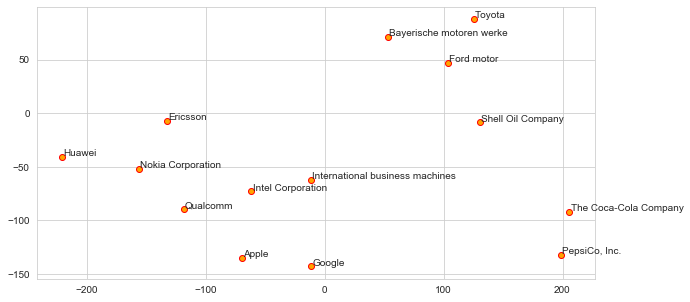

In [112]:
#use t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=5)
np.set_printoptions(suppress=True)
result = tsne.fit_transform(tfidf_vectors.toarray())
labels = asg_list

plt.figure(figsize=(10, 5))
plt.scatter(result[:, 0], result[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, result[:, 0], result[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    

In [121]:
from sklearn.metrics.pairwise import cosine_similarity
row_list = []
for i in range(tfidf_vectors.shape[0]):
    for j in range(i+1, tfidf_vectors.shape[0]):
        w = linear_kernel(tfidf_vectors[i], tfidf_vectors[j]).flatten()
        row_list.append({"weight": w, "asg_A": asg_list[i], "asg_B": asg_list[j]})
company_cosine_similarity_tfidf_df = pd.DataFrame(row_list)

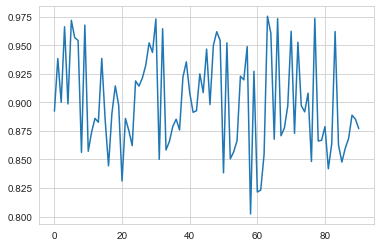

In [123]:
plt.plot(company_cosine_similarity_tfidf_df['weight'])

Obviously, cosine similarity is not suitable for comparing companies using their tfidf matrix.